<a href="https://colab.research.google.com/github/Anujjadaun97/License-plate-recognition-using-CNN/blob/main/License_plate_recognition_using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle

In [2]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"anujjadaun97","key":"a57ec96ae6386040102e854119519439"}'}

In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [4]:
!kaggle datasets download -d sarthakvajpayee/ai-indian-license-plate-recognition-data

Dataset URL: https://www.kaggle.com/datasets/sarthakvajpayee/ai-indian-license-plate-recognition-data
License(s): unknown
  0% 0.00/1.50M [00:00<?, ?B/s]
100% 1.50M/1.50M [00:00<00:00, 613MB/s]


In [5]:
!unzip ai-indian-license-plate-recognition-data

Archive:  ai-indian-license-plate-recognition-data.zip
  inflating: car.jpg                 
  inflating: data/data/train/class_0/class_0_10.jpg  
  inflating: data/data/train/class_0/class_0_11.jpg  
  inflating: data/data/train/class_0/class_0_13.jpg  
  inflating: data/data/train/class_0/class_0_14.jpg  
  inflating: data/data/train/class_0/class_0_15.jpg  
  inflating: data/data/train/class_0/class_0_18.jpg  
  inflating: data/data/train/class_0/class_0_19.jpg  
  inflating: data/data/train/class_0/class_0_2.jpg  
  inflating: data/data/train/class_0/class_0_20.jpg  
  inflating: data/data/train/class_0/class_0_21.jpg  
  inflating: data/data/train/class_0/class_0_22.jpg  
  inflating: data/data/train/class_0/class_0_23.jpg  
  inflating: data/data/train/class_0/class_0_24.jpg  
  inflating: data/data/train/class_0/class_0_25.jpg  
  inflating: data/data/train/class_0/class_0_26.jpg  
  inflating: data/data/train/class_0/class_0_27.jpg  
  inflating: data/data/train/class_0/class_0

In [6]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [8]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


In [9]:
DATASET_PATH = "/content/data/data"  # Adjusted to the correct path where data was unzipped

train_data = datasets.ImageFolder(
    root=os.path.join(DATASET_PATH, "train"),
    transform=transform
)

test_data = datasets.ImageFolder(
    root=os.path.join(DATASET_PATH, "val"), # Assuming 'val' is the test set based on unzip output
    transform=transform
)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

class_names = train_data.classes
num_classes = len(class_names)

print("Classes:", class_names)
print("Total classes:", num_classes)

Classes: ['class_0', 'class_1', 'class_2', 'class_3', 'class_4', 'class_5', 'class_6', 'class_7', 'class_8', 'class_9', 'class_A', 'class_B', 'class_C', 'class_D', 'class_E', 'class_F', 'class_G', 'class_H', 'class_I', 'class_J', 'class_K', 'class_L', 'class_M', 'class_N', 'class_O', 'class_P', 'class_Q', 'class_R', 'class_S', 'class_T', 'class_U', 'class_V', 'class_W', 'class_X', 'class_Y', 'class_Z']
Total classes: 36


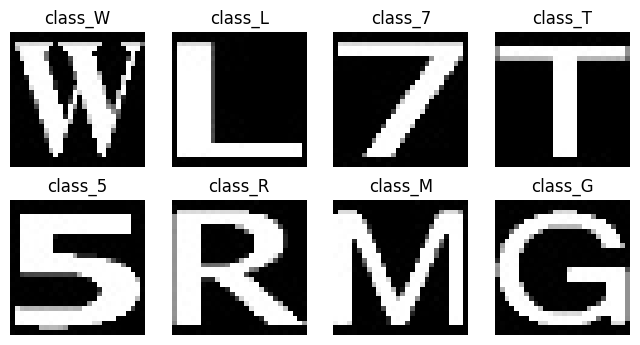

In [10]:
images, labels = next(iter(train_loader))

plt.figure(figsize=(8,4))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(images[i].squeeze(), cmap="gray")
    plt.title(class_names[labels[i]])
    plt.axis("off")
plt.show()


In [11]:
class LicenseCharCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 3 * 3, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [12]:
model = LicenseCharCNN(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [13]:
epochs = 10

for epoch in range(epochs):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{epochs}] Loss: {running_loss:.4f} Accuracy: {acc:.2f}%")


Epoch [1/10] Loss: 49.6546 Accuracy: 5.79%
Epoch [2/10] Loss: 38.0702 Accuracy: 28.12%
Epoch [3/10] Loss: 17.6972 Accuracy: 61.92%
Epoch [4/10] Loss: 8.5245 Accuracy: 81.02%
Epoch [5/10] Loss: 5.8170 Accuracy: 86.57%
Epoch [6/10] Loss: 3.6485 Accuracy: 90.28%
Epoch [7/10] Loss: 2.5466 Accuracy: 92.71%
Epoch [8/10] Loss: 2.4441 Accuracy: 94.91%
Epoch [9/10] Loss: 1.7395 Accuracy: 95.60%
Epoch [10/10] Loss: 1.3919 Accuracy: 96.76%


In [14]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print("Test Accuracy:", 100 * correct / total)


Test Accuracy: 98.61111111111111


In [15]:
import PIL.Image

img_path = "/content/data/data/val/class_A/class_A_1.jpg"  # Corrected path to an example image
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

if img is None:
    print(f"Error: Image not found at {img_path}")
else:
    img = cv2.resize(img, (28,28))
    img_pil = PIL.Image.fromarray(img) # Convert NumPy array to PIL Image

    img_tensor = transform(img_pil).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(img_tensor)
        pred = torch.argmax(output, dim=1)

    print("Predicted Character:", class_names[pred.item()])

Predicted Character: class_A


In [16]:
!pip install ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 76.0 MB/s eta 0:00:00


In [17]:
from ultralytics import YOLO

# Load pretrained plate detection model
plate_model = YOLO("yolov8n.pt")  # base model


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [18]:
import cv2
import matplotlib.pyplot as plt

img_path = "/content/car.jpg"  # any car image
img = cv2.imread(img_path)

results = plate_model(img)



0: 448x640 1 car, 74.7ms
Speed: 9.9ms preprocess, 74.7ms inference, 2.7ms postprocess per image at shape (1, 3, 448, 640)


In [19]:
plates = []

for r in results:
    for box in r.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        plates.append(img[y1:y2, x1:x2])


(np.float64(-0.5), np.float64(272.5), np.float64(177.5), np.float64(-0.5))

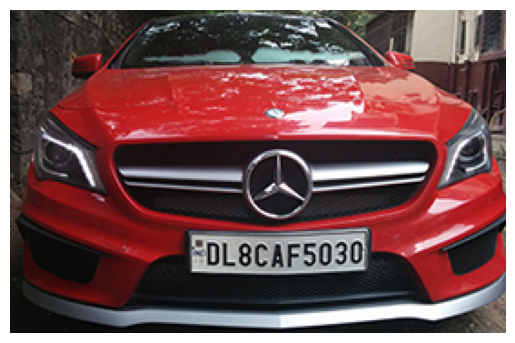

In [20]:
plt.imshow(cv2.cvtColor(plates[0], cv2.COLOR_BGR2RGB))
plt.axis("off")


In [21]:
def preprocess_plate(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    thresh = cv2.adaptiveThreshold(
        blur, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV, 11, 2
    )
    return thresh


(np.float64(-0.5), np.float64(272.5), np.float64(177.5), np.float64(-0.5))

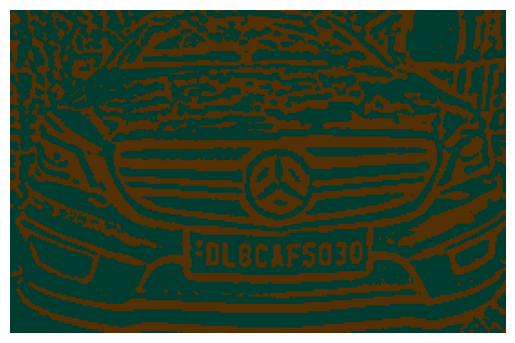

In [22]:
processed_plate = preprocess_plate(plates[0])
plt.imshow(processed_plate, cmap="BrBG_r")
plt.axis("off")


In [23]:
def segment_characters(thresh):
    contours, _ = cv2.findContours(
        thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )

    chars = []
    for cnt in contours:
        x,y,w,h = cv2.boundingRect(cnt)
        if h > 20 and w > 10:  # filter noise
            char = thresh[y:y+h, x:x+w]
            chars.append((x, char))

    chars = sorted(chars, key=lambda x: x[0])
    return [c[1] for c in chars]


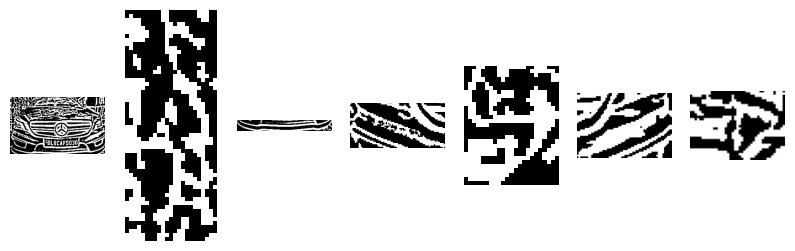

In [24]:
chars = segment_characters(processed_plate)

plt.figure(figsize=(10,3))
for i,c in enumerate(chars):
    plt.subplot(1,len(chars),i+1)
    plt.imshow(c, cmap="gray")
    plt.axis("off")


In [25]:
def recognize_characters(chars, model, class_names):
    plate_text = ""

    for c in chars:
        c = cv2.resize(c, (28,28))
        c = torch.tensor(c).unsqueeze(0).unsqueeze(0).float() / 255.0
        c = c.to(device)

        with torch.no_grad():
            output = model(c)
            pred = torch.argmax(output, dim=1)

        plate_text += class_names[pred.item()]

    return plate_text


In [26]:
plate_number = recognize_characters(chars, model, class_names)
print("Detected Plate Number:", plate_number)


Detected Plate Number: class_Bclass_Bclass_Bclass_Bclass_Bclass_Bclass_B


In [27]:
import PIL.Image

# Function to recognize characters using the trained PyTorch model
def predict_plate_pytorch(segmented_chars, model, class_names, transform, device):
    plate_text = ""
    model.eval() # Set model to evaluation mode

    for char_img_np in segmented_chars:
        # Resize the character image to 28x28 (model input size requirement)
        resized_char = cv2.resize(char_img_np, (28, 28), interpolation=cv2.INTER_AREA)

        # Convert numpy array to PIL Image as expected by the transform
        img_pil = PIL.Image.fromarray(resized_char)

        # Apply the same transformations used for training
        img_tensor = transform(img_pil).unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(img_tensor)
            pred = torch.argmax(output, dim=1)

        plate_text += class_names[pred.item()].replace('class_', '') # Extract the character from 'class_X'

    return plate_text

# Call the new function with the existing variables
# 'chars' is the list of segmented character images from cell '_0BxT_acUsS8'
# 'model' is the trained PyTorch model from cell 'locF3T3TTp0i'
# 'class_names' is the list of class labels from cell '70GYA5F2Rcuy'
# 'transform' is the image transformation pipeline from cell '3qds6-QKRRKn'
# 'device' is the computational device (cuda/cpu) from cell 'UoiUTk2tRN5O'
plate_number_predicted = predict_plate_pytorch(chars, model, class_names, transform, device)
print("Detected Plate Number (PyTorch model):", plate_number_predicted)

Detected Plate Number (PyTorch model): 4WJWBZ4


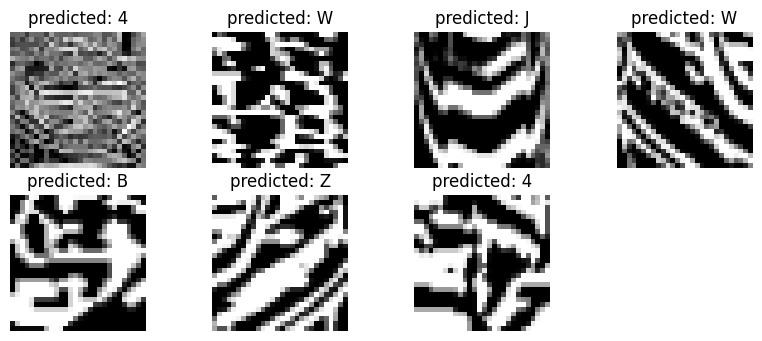

In [28]:
# Segmented characters and their predicted value.
plt.figure(figsize=(10,6))

# Ensure 'chars' is the correct list of segmented images
# Ensure 'plate_number_predicted' is the string of predicted characters

# Convert plate_number_predicted string into a list of individual characters
predicted_chars_list = list(plate_number_predicted)

# Check if the number of segmented images matches the number of predicted characters
if len(chars) != len(predicted_chars_list):
    print("Warning: Number of segmented characters does not match number of predicted characters. Displaying up to the minimum count.")
    display_len = min(len(chars), len(predicted_chars_list))
else:
    display_len = len(chars)

for i in range(display_len):
    ch = chars[i]
    predicted_char = predicted_chars_list[i]

    # Resize for display (already done for prediction by the function predict_plate_pytorch)
    img = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
    plt.subplot(3,4,i+1) # Adjust subplot size if more than 12 characters are expected
    plt.imshow(img,cmap='gray')
    plt.title(f'predicted: {predicted_char}')
    plt.axis('off')
plt.show()

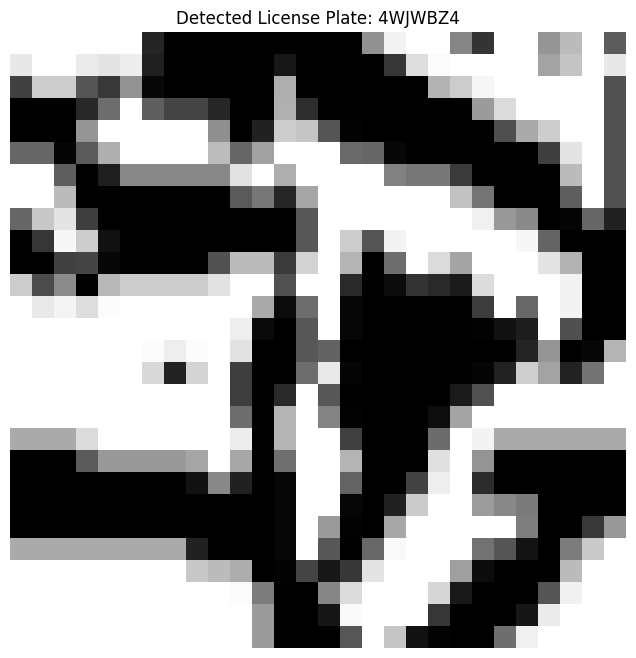

In [29]:
# Assuming 'img' is the original car image and 'results' contains the YOLO detections
# Assuming 'plate_number_predicted' holds the recognized text

output_img = img.copy() # Create a copy to draw on

# Get the bounding box from the YOLO results (assuming only one plate is detected for simplicity)
if results and results[0].boxes:
    box = results[0].boxes[0] # Get the first detected box
    x1, y1, x2, y2 = map(int, box.xyxy[0])

    # Draw bounding box on the original image
    cv2.rectangle(output_img, (x1, y1), (x2, y2), (0, 255, 0), 2) # Green rectangle

    # Put the recognized text on the image
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(output_img, plate_number_predicted, (x1, y1 - 10), font, 0.9, (0, 255, 0), 2, cv2.LINE_AA)

# Display the image with the detected plate and recognized text
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))
plt.title(f'Detected License Plate: {plate_number_predicted}')
plt.axis('off')
plt.show()